# Image Classification of ATLAS Calorimeter Topo-Clusters: Let's Try 2D CNNs

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#import libraries and some constants

import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LogNorm
import pandas as pd
import uproot as ur
import atlas_mpl_style as ampl
ampl.use_atlas_style()

path_prefix = '/home/mswiatlowski/start_tf/caloml-atlas-new/'
plotpath = path_prefix+'classifier/Plots/'
modelpath = path_prefix+'classifier/Models/'

In [3]:
# import our resolution utilities

import sys
sys.path.append(path_prefix)
from  util import resolution_util as ru
from  util import plot_util as pu
from  util import ml_util as mu

Using TensorFlow backend.


In [4]:
inputpath = '/fast_scratch/atlas_images/v7/'
rootfiles = ["pi0", "piplus", "piminus"]

trees, pdata = mu.setupPionData(inputpath, rootfiles)

In [5]:
np0 = len(pdata['pi0'])
npp = len(pdata['piplus'])
npm = len(pdata['piminus'])

print("Number of pi0 events: {}".format(np0))
print("Number of pi+ events: {}".format(npp))
print("Number of pi- events: {}".format(npm))
print("Total: {}".format(np0+npp+npm))

Number of pi0 events: 263891
Number of pi+ events: 435967
Number of pi- events: 434627
Total: 1134485


In [6]:
pcells = {
    ifile : {
        layer : mu.setupCells(itree, layer, flatten = False)
        for layer in mu.cell_meta
    }
    for ifile, itree in trees.items()
}

## Can we train the CNN still?

In [7]:
import numpy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Convolution2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras import Model

In [8]:
import tensorflow as tf

gpu_list = ["/gpu:2", "/gpu:3"]
strategy = tf.distribute.MirroredStrategy(devices=gpu_list)
# strategy = tf.distribute.MirroredStrategy()
ngpu = strategy.num_replicas_in_sync
print ('Number of devices: {}'.format(ngpu))

Number of devices: 2


In [9]:
training_classes = ['pi0','piplus']
# create train/validation/test subsets containing 70%/10%/20%
# of events from each type of pion event
pdata_merged, pcells_merged, plabels = mu.createTrainingDatasets(training_classes, pdata, pcells)

In [10]:
pcells_merged_reshaped = mu.reshapeSeparateCNN(pcells_merged)

In [11]:
# not sure how useful these 1,1 filters are?
# may need 'shallower' networks instead for the further networks
filters = {
    'EMB1': (2,4), 
    'EMB2': (4,4), 
    'EMB3': (4,2), 
    'TileBar0': (2,2), 
    'TileBar1': (2,2), 
    'TileBar2': (1,1)
}
pools2 = {
    'EMB1': (2,2), 
    'EMB2': (2,2), 
    'EMB3': (1,1), 
    'TileBar0': (1,1), 
    'TileBar1': (1,1), 
    'TileBar2': (1,1)
}

In [12]:
def cnn_model_layers(layer):
    print(layer)
    # create model
    with strategy.scope():
        model = Sequential()
        model.add(Convolution2D(32, filters[layer], input_shape=(1,mu.cell_meta[layer]['len_eta'],mu.cell_meta[layer]['len_phi']), activation='relu', data_format = 'channels_first'))
        model.add(MaxPool2D(pool_size=(2, 2)))
        # model.add(Convolution2D(16, (2, 2), activation='relu'))
        model.add(Convolution2D(16, pools2[layer], activation='relu'))
        model.add(MaxPool2D(pool_size=pools2[layer]))
        model.add(Flatten())
        model.add(Dense(128, activation='relu'))
        model.add(Dense(50, activation='relu'))
        model.add(Dense(2, kernel_initializer='normal', activation='softmax'))
        # compile model
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
        return model

In [13]:
models = {
    layer: cnn_model_layers(layer)
    for layer in mu.cell_meta
}

EMB1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
EMB2
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
EMB3
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
TileBar0
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0'

In [16]:
history = {
    layer: models[layer].fit(pcells_merged_reshaped[layer][pdata_merged.train], 
                                plabels[pdata_merged.train], 
                                validation_data=(pcells_merged_reshaped[layer][pdata_merged.val], plabels[pdata_merged.val]),                                   epochs=100, batch_size=200*ngpu, verbose=2)
    for layer in mu.cell_meta
}

 0.7090
Train on 489899 samples, validate on 69988 samples
Epoch 1/100
INFO:tensorflow:batch_all_reduce: 10 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
INFO:tensorflow:batch_all_reduce: 10 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
489899/489899 - 14s - loss: 0.5330 - acc: 0.6379 - val_loss: 0.5202 - val_acc: 0.6540
Epoch 2/100
489899/489899 - 8s - loss: 0.5209 - acc: 0.6421 - val_loss: 0.5166 - val_acc: 0.6531
Epoch 3/100
489899/489899 - 9s - loss: 0.5206 - acc: 0.6448 - val_loss: 0.5198 - val_acc: 0.6503
Epoch 4/100
489899/489899 - 9s - loss: 0.5197 - acc: 0.6470 - val_loss: 0.5162 - val_acc: 0.6536
Epoch 5/100
489899/489899 - 9s - loss: 0.5190 - acc: 0.6485 - val_loss: 0.5172 - val_acc: 0.6509
Epoch 6/100
489899/489899 - 9s - loss: 0.5186 - acc: 0.6491 - val_loss: 0.5185 - val_acc: 0.6492
Epoch 7/100
489899/489899 - 9s - loss: 0.5188 - acc: 0

In [17]:
performance = {}
scores = {}
for layer in mu.cell_meta:
    print('On layer ' + layer)
    
    # get overall performance metric
    performance[layer] = models[layer].evaluate(
        pcells_merged_reshaped[layer][pdata_merged.test], plabels[pdata_merged.test],
        verbose = 0,
    )
    
    # get network scores for the dataset
    scores[layer] = models[layer].predict(
        pcells_merged_reshaped[layer]
    )
    
    print('Finished layer ' + layer)


On layer EMB1
Finished layer EMB1
On layer EMB2
Finished layer EMB2
On layer EMB3
Finished layer EMB3
On layer TileBar0
Finished layer TileBar0
On layer TileBar1
Finished layer TileBar1
On layer TileBar2
Finished layer TileBar2


<Figure size 576x432 with 0 Axes>

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


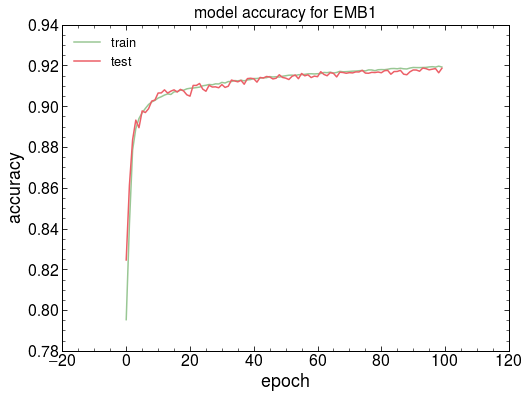

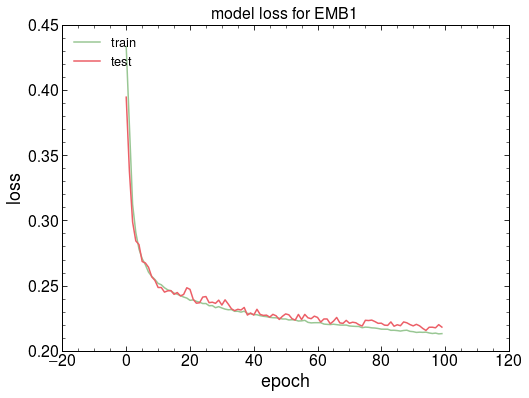

<Figure size 576x432 with 0 Axes>

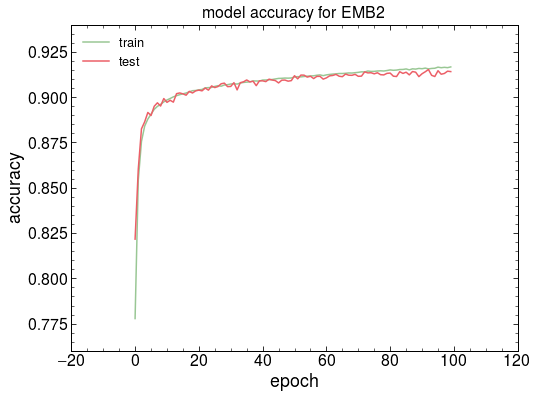

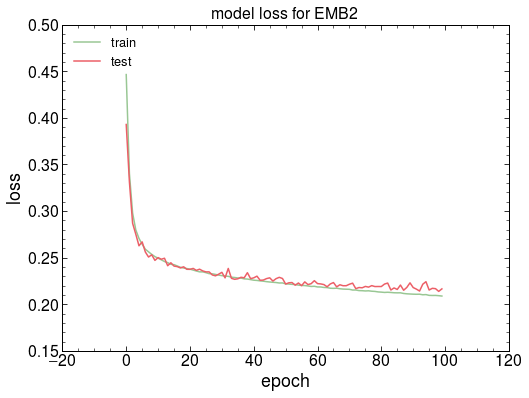

<Figure size 576x432 with 0 Axes>

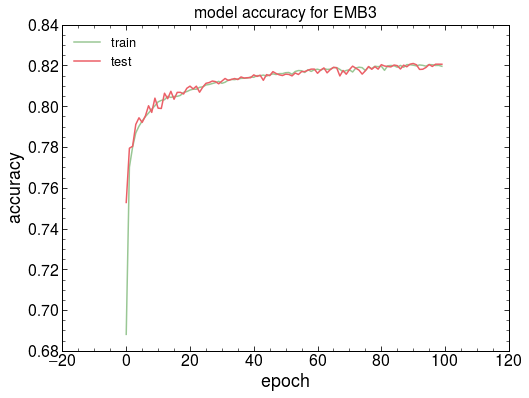

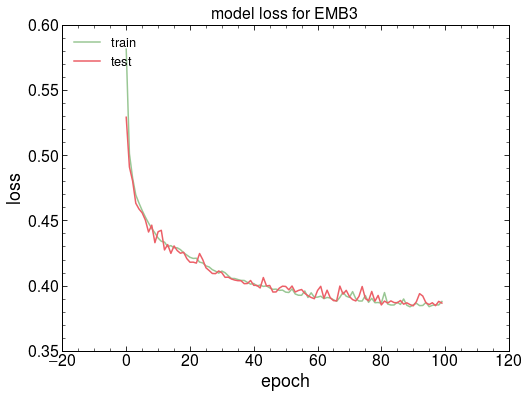

<Figure size 576x432 with 0 Axes>

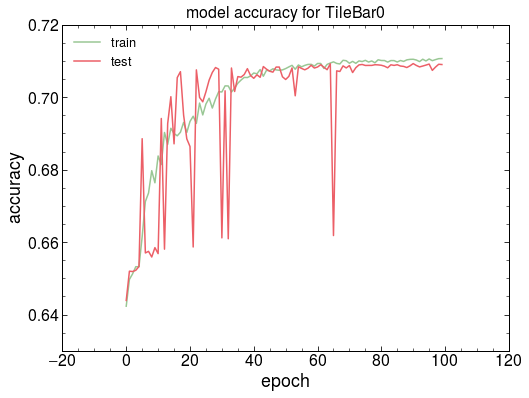

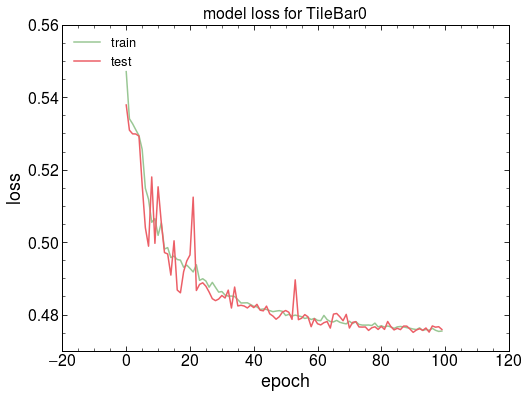

<Figure size 576x432 with 0 Axes>

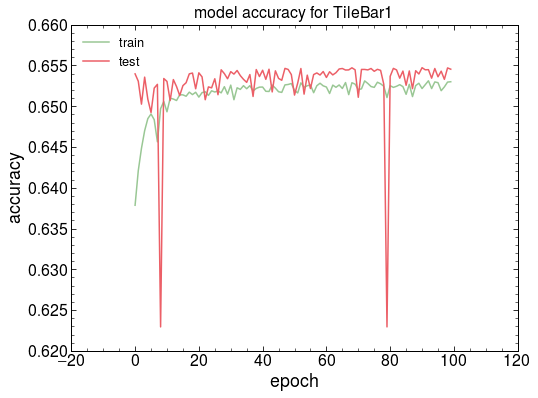

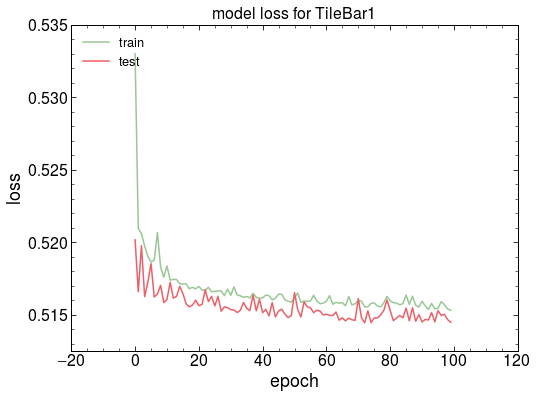

<Figure size 576x432 with 0 Axes>

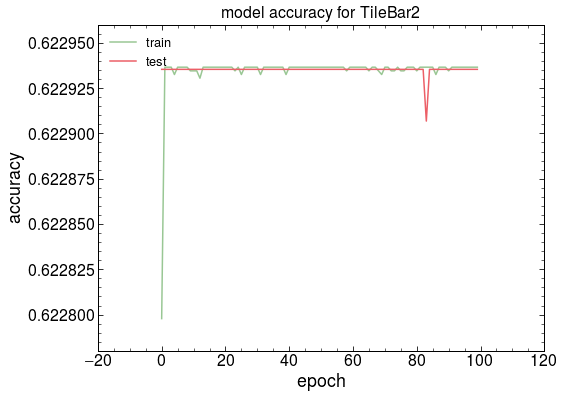

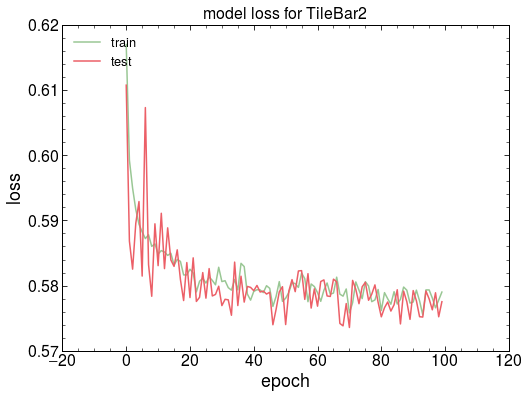

In [20]:
for layer in mu.cell_meta:
#     print(history_flat[layer_i].history.keys())
    plt.cla(); plt.clf()
    fig = plt.figure()
    fig.patch.set_facecolor('white')

    plt.plot(history[layer].history['acc'])
    plt.plot(history[layer].history['val_acc'])
    plt.title('model accuracy for ' + layer)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    # plt.savefig('Plots/accuracy_' + layer + '.pdf')
    plt.show()


    # summarize history for loss
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.plot(history[layer].history['loss'])
    plt.plot(history[layer].history['val_loss'])
    plt.title('model loss for ' + layer)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    # plt.savefig(plotpath + 'loss_' + layer + '.pdf')
    plt.show()

In [21]:
from sklearn.metrics import roc_curve, auc

roc_fpr = {}
roc_tpr = {}
roc_thresh = {}
roc_auc = {}

for layer in mu.cell_meta:
    roc_fpr[layer], roc_tpr[layer], roc_thresh[layer] = roc_curve(
        plabels[pdata_merged.test][:,1],
        scores[layer][pdata_merged.test,1],
        drop_intermediate=False,
    )
    roc_auc[layer] = auc(roc_fpr[layer], roc_tpr[layer])
    print('Area under curve for ' + layer + ': ' + str(roc_auc[layer]))

Area under curve for EMB1: 0.9659489260552804
Area under curve for EMB2: 0.9673279016738194
Area under curve for EMB3: 0.8810828325545005
Area under curve for TileBar0: 0.7880961395999703
Area under curve for TileBar1: 0.7212860433584309
Area under curve for TileBar2: 0.6347230056056876


/home/mswiatlowski/start_tf/caloml-atlas-new/util/plot_util.py:141: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(figfile)


<Figure size 576x432 with 0 Axes>

/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


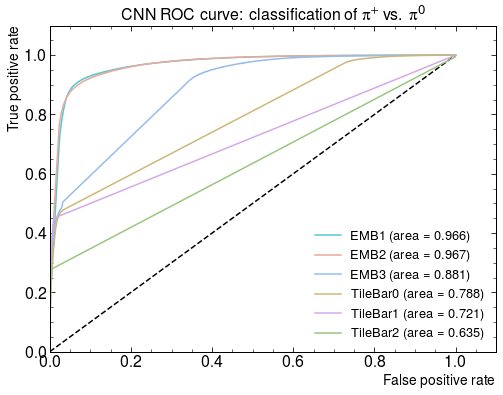

In [23]:
pu.roc_plot([roc_fpr[layer] for layer in mu.cell_meta],
            [roc_tpr[layer] for layer in mu.cell_meta],
            figfile=plotpath + 'roc_cnn_all.pdf',
            labels=['{} (area = {:.3f})'.format(layer, roc_auc[layer]) for layer in mu.cell_meta],
            extra_lines=[[[0, 1], [0, 1]]],
            title='CNN ROC curve: classification of $\pi^+$ vs. $\pi^0$')

## More with CNN's

In [29]:
def merged_model_emb123():
    with strategy.scope():
        # EMB1 image (flat, fully-connected)
        input1 = Input(shape=(1, 128, 4), name='input1')
        x1 = Convolution2D(32, (4, 2), activation='relu', data_format = 'channels_first')(input1)
        x1 = MaxPool2D(pool_size=(2, 2))(x1)
        x1 = Dropout(0.2)(x1)
        x1 = Flatten()(x1)
        x1 = Dense(128, activation='relu')(x1)

        # EMB2 image (convolutional)
        input2 = Input(shape=(1,16,16), name='input2')
        x2 = Convolution2D(32, (4, 4), activation='relu', data_format = 'channels_first')(input2)
        x2 = MaxPool2D(pool_size=(2, 2))(x2)
        x2 = Dropout(0.2)(x2)
        x2 = Flatten()(x2)
        x2 = Dense(128, activation='relu')(x2)
    
        # EMB3 image (convolutional)
        input3 = Input(shape=(1,8,16), name='input3')
        x3 = Convolution2D(32, (2, 4), activation='relu', data_format = 'channels_first')(input3)
        x3 = MaxPool2D(pool_size=(1, 2))(x3)
        x3 = Dropout(0.2)(x3)
        x3 = Flatten()(x3)
        x3 = Dense(128, activation='relu')(x3)

        # concatenate outputs from the three networks above
        x = concatenate([x1, x2, x3]) 
        x = Dense(50, activation='relu')(x)    

        # final output
        output = Dense(2, activation='softmax')(x)

        model = Model(inputs = [input1, input2, input3], outputs = [output])
    
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])    
        return model

In [30]:
merged_emb123 = merged_model_emb123()


In [13]:
tf.keras.utils.plot_model(merged_emb123, plotpath+'emb123_with_shape_info.png', show_shapes=True)


Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [31]:
history_emb123 = merged_emb123.fit([pcells_merged_reshaped['EMB1'][pdata_merged.train],
                                    pcells_merged_reshaped['EMB2'][pdata_merged.train],
                                    pcells_merged_reshaped['EMB3'][pdata_merged.train]],
                                    plabels[pdata_merged.train], 
                                    validation_data=([pcells_merged_reshaped['EMB1'][pdata_merged.val],
                                                        pcells_merged_reshaped['EMB2'][pdata_merged.val],
                                                        pcells_merged_reshaped['EMB3'][pdata_merged.val]], 
                                                        plabels[pdata_merged.val]),                            
                                    epochs=250, batch_size=200*ngpu, verbose=2)

cy: 0.9438
Epoch 69/250
489899/489899 - 13s - loss: 0.1588 - accuracy: 0.9425 - val_loss: 0.1593 - val_accuracy: 0.9434
Epoch 70/250
489899/489899 - 13s - loss: 0.1586 - accuracy: 0.9426 - val_loss: 0.1660 - val_accuracy: 0.9419
Epoch 71/250
489899/489899 - 13s - loss: 0.1584 - accuracy: 0.9429 - val_loss: 0.1583 - val_accuracy: 0.9434
Epoch 72/250
489899/489899 - 13s - loss: 0.1582 - accuracy: 0.9428 - val_loss: 0.1604 - val_accuracy: 0.9435
Epoch 73/250
489899/489899 - 13s - loss: 0.1580 - accuracy: 0.9428 - val_loss: 0.1587 - val_accuracy: 0.9439
Epoch 74/250
489899/489899 - 13s - loss: 0.1579 - accuracy: 0.9432 - val_loss: 0.1593 - val_accuracy: 0.9434
Epoch 75/250
489899/489899 - 13s - loss: 0.1575 - accuracy: 0.9432 - val_loss: 0.1599 - val_accuracy: 0.9437
Epoch 76/250
489899/489899 - 13s - loss: 0.1575 - accuracy: 0.9430 - val_loss: 0.1603 - val_accuracy: 0.9430
Epoch 77/250
489899/489899 - 13s - loss: 0.1570 - accuracy: 0.9432 - val_loss: 0.1580 - val_accuracy: 0.9440
Epoch 78

In [18]:
print(history_emb123.history)

{'loss': [0.30461336122653143, 0.2272190349493336, 0.21099025621625184, 0.20208871338720974, 0.19704965426658463, 0.19331805333939073, 0.19063971208040845, 0.188365321041915, 0.18665064336583798, 0.1850034644652985, 0.1828766229398756, 0.18229472967058905, 0.18110112664278946, 0.17994098618304694, 0.17862303087618034, 0.17775006677355593, 0.1769877529478884, 0.17607079010859694, 0.1750110997841822, 0.17407985343434787, 0.17336786054414444, 0.17252181917286924, 0.1721530519040412, 0.17121298576333813, 0.1704106819515083, 0.16957511715749046, 0.16860791848572448, 0.16848665427893247, 0.16789101896545766, 0.16685870998368052, 0.16623950347955962, 0.16587756750185062, 0.16569138840941522, 0.16450645913563575, 0.1644586091682031, 0.16366989846347074, 0.16295264697523307, 0.16222779111454266, 0.16196070014337272, 0.16104685151768183, 0.16091818731769406, 0.16000555219671564, 0.15958408451335895, 0.1591740163451232, 0.15853851812874292, 0.15820999349360615, 0.15768967036127102, 0.157324876972

<Figure size 576x432 with 0 Axes>

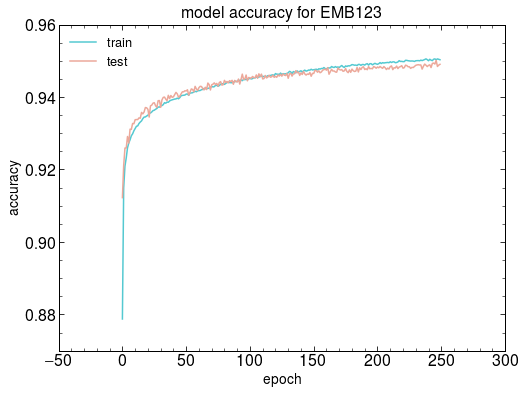

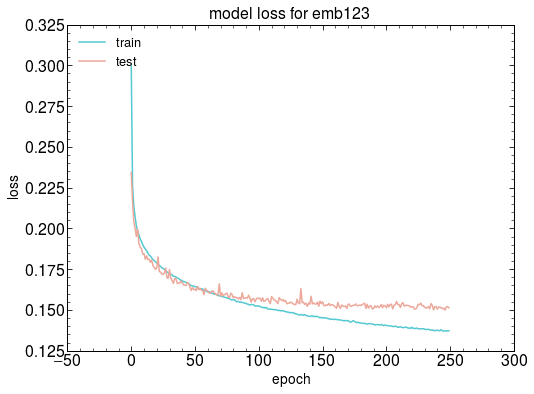

In [32]:
    plt.cla(); plt.clf()
    fig = plt.figure()
    fig.patch.set_facecolor('white')

    plt.plot(history_emb123.history['accuracy'])
    plt.plot(history_emb123.history['val_accuracy'])
    plt.title('model accuracy for EMB123')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    # plt.savefig('Plots/accuracy_' + layer + '.pdf')
    plt.show()


    # summarize history for loss
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.plot(history_emb123.history['loss'])
    plt.plot(history_emb123.history['val_loss'])
    plt.title('model loss for emb123')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    # plt.savefig(plotpath + 'loss_' + layer + '.pdf')
    plt.show()

In [33]:
scores_123 = merged_emb123.predict(
        [pcells_merged_reshaped['EMB1'], pcells_merged_reshaped['EMB2'], pcells_merged_reshaped['EMB3']]
        )

In [26]:
from sklearn.metrics import roc_curve, auc
roc_fpr_123, roc_tpr_123, roc_thresh_123 = roc_curve(
        plabels[pdata_merged.test][:,1],
        scores_123[pdata_merged.test,1],
        drop_intermediate=False,
    )
roc_auc_123 = auc(roc_fpr_123, roc_tpr_123)
print('Area under curve for EMB123 ' + str(roc_auc_123))

Area under curve for EMB123 0.9835162343799436
